# Music Genre Classification
In this notebook I tried to learn the basic concepts of neural networks and use it to classify the music files in dataset. Majorly this notebook can be divided into 3 parts:

   1) Using ANN 

   2) Tackling overfitting with ANN

   3) Using CNN


Also to read the dataset I have used librosa library which only read files <1Mb and one file is greater than the size giving error due to which I have ignored it. The dataset contains the following genres, the keys being the prediction targets
    
    0: "disco",
    1: "metal",
    2: "reggae",
    3: "blues",
    4: "rock",
    5: "classical",
    6: "jazz",
    7: "hiphop",
    8: "country",
    9: "pop"


In [1]:
import os
import librosa
import math
import json 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset_path = r"Data/genres_original"
json_path = r"data.json"
SAMPLE_RATE = 22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

In [3]:
def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": [],
    }
    samples_ps = int(SAMPLES_PER_TRACK/num_segments)
    expected_vects_ps = math.ceil(samples_ps/hop_length)
    
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath is not dataset_path:
            dirpath_comp = dirpath.split("/")
            semantic_label = dirpath_comp[-1]
            data["mapping"].append(semantic_label)
            print(f"Processing: {semantic_label}")
            
            for f in filenames:
                if f == "jazz.00054.wav":  # Check if this condition is necessary
                    continue
                else:
                    file_path = os.path.join(dirpath, f)
                    print(f"Processing file: {file_path}")
                    
                    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                    print(f"Loaded signal with sampling rate: {sr}")
                    
                    for s in range(num_segments):
                        start_sample = samples_ps * s
                        finish_sample = start_sample + samples_ps
                        print(f"Segment {s+1}: Start Sample: {start_sample}, Finish Sample: {finish_sample}")
                        
                        mfcc = librosa.feature.mfcc(y=signal[start_sample:finish_sample],
                            sr=sr,
                            n_fft=n_fft,
                            n_mfcc=n_mfcc,
                            hop_length=hop_length)

                        mfcc = mfcc.T

                        if len(mfcc) == expected_vects_ps:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                            print(f"{file_path}, segment: {s+1}")

    with open(json_path, "w") as f:
        json.dump(data, f, indent=4)



In [4]:
from IPython.display import clear_output

In [5]:
save_mfcc(dataset_path,json_path,num_segments=10)
clear_output()

In [6]:
filepath = r"Data/genres_original/blues/blues.0000"

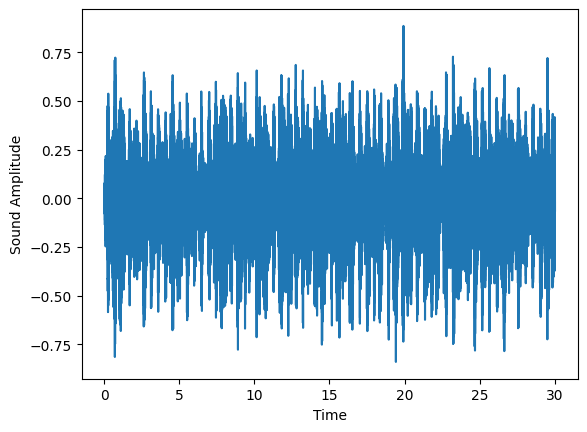

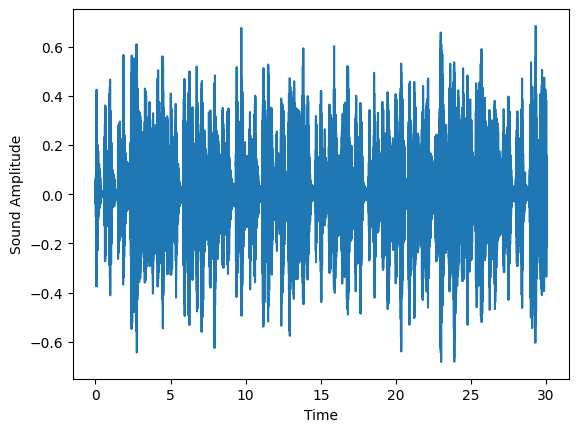

In [7]:
for i in range(2):
    audio, sfreq = librosa.load(filepath+str(i)+".wav")
    time = np.arange(0, len(audio))/sfreq
    plt.plot(time,audio)
    plt.xlabel("Time")
    plt.ylabel("Sound Amplitude")
    plt.show()

# Classifier
This part uses the concepts of ANN with keras and sequential layers. I have also done splitting in the ratio 70:30

The model is Sequential and architecture only has Flatten and the Dense layers available in keras for the basic ANN representation. As it is naive model we can expect it to be overfit. Info on the layers can be found [here](https://machinelearningknowledge.ai/different-types-of-keras-layers-explained-for-beginners/)

In [8]:
import json
import numpy as np

In [9]:
# load data
def load_data(dataset_path):
    with open(dataset_path,"r") as f:
        data = json.load(f)
    
    # Convert list to numpy arrays
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])    
    
    return inputs,targets

In [10]:
inputs,targets = load_data(r"data.json")

In [11]:
# splitting the data
from sklearn.model_selection import train_test_split

input_train, input_test, target_train, target_test = train_test_split(inputs, targets, test_size=0.3)
print(input_train.shape, target_train.shape)

(6990, 130, 13) (6990,)


In [12]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

In [13]:
model = Sequential()

model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

C:\Users\Prasad Raju\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 1690)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         865,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,014,218 (3.87 MB)

 Trainable params: 1,014,218 (3.87 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from tensorflow.keras import optimizers

adam = optimizers.Adam(learning_rate=1e-4)

In [17]:
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [18]:
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

hist = model.fit(input_train, target_train,
                 validation_data = (input_test,target_test),
                 epochs = 50,
                 batch_size = 32)


In [19]:
def plot_history(hist):
    plt.figure(figsize=(20,15))
    fig, axs = plt.subplots(2)
    # accuracy subplot
    axs[0].plot(hist.history["accuracy"], label="train accuracy")
    axs[0].plot(hist.history["val_accuracy"], label="test accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    
    # Error subplot
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="test error")    
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.show()

<Figure size 2000x1500 with 0 Axes>

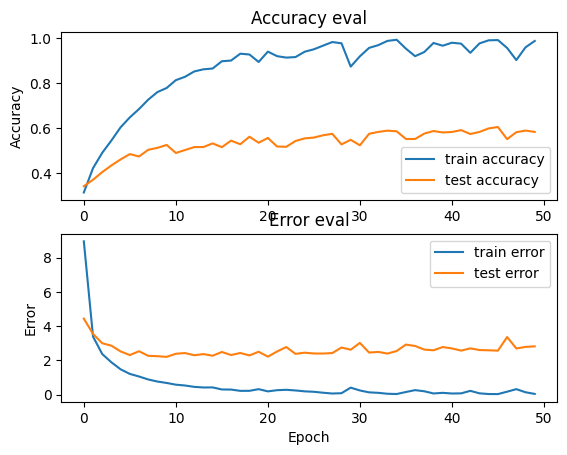

In [20]:
plot_history(hist)

In [21]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6026 - loss: 2.6398
Test accuracy: 0.5844459533691406


# Overfitting
This part deals with the overfitting of the previous model. We can deal with it by majorly doing the following process.
- Making architecture less complicated 
- Using augmented data
- Early stopping of training
- Adding dropout layers
- Regularization / Standardization  

I have added the dropout layers and kernel_regularizers as compared to previous naive model giving the dropout probability as 30%
Kernel_regularizers is one of the 3 type of regularizer used to impose penalties. More info can be found [here](https://medium.com/@robertjohn_15390/regularization-in-tensorflow-using-keras-api-48aba746ae21)

In [22]:
import tensorflow.keras as keras

In [23]:
# Overfitting
model = Sequential()

model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu', kernel_regularizer = keras.regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu', kernel_regularizer = keras.regularizers.l2(0.003)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer = keras.regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 1690)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         865,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,015,978 (3.88 MB)

 Trainable params: 1,015,978 (3.88 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
from tensorflow.keras import optimizers

# Create a new instance of the optimizer
adam = optimizers.Adam(learning_rate=1e-4)

# Compile the model with the new optimizer instance
model.compile(optimizer=adam,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Fit the model
hist = model.fit(input_train, target_train,
                 validation_data=(input_test, target_test),
                 epochs=50,
                 batch_size=32)


Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.1297 - loss: 31.2168 - val_accuracy: 0.1789 - val_loss: 5.0529
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.1521 - loss: 7.7113 - val_accuracy: 0.1659 - val_loss: 5.0042
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.1541 - loss: 5.9469 - val_accuracy: 0.1435 - val_loss: 5.0024
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.1582 - loss: 5.4534 - val_accuracy: 0.1615 - val_loss: 4.9528
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.1758 - loss: 5.2282 - val_accuracy: 0.1686 - val_loss: 4.9236
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.1729 - loss: 5.0943 - val_accuracy: 0.2146 - val_loss: 4.8272
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.1900 - loss: 4.9843 - val_accuracy: 0.2280 - val_loss: 4.7827
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.2137 - loss: 4.9154 - val_acc

<Figure size 2000x1500 with 0 Axes>

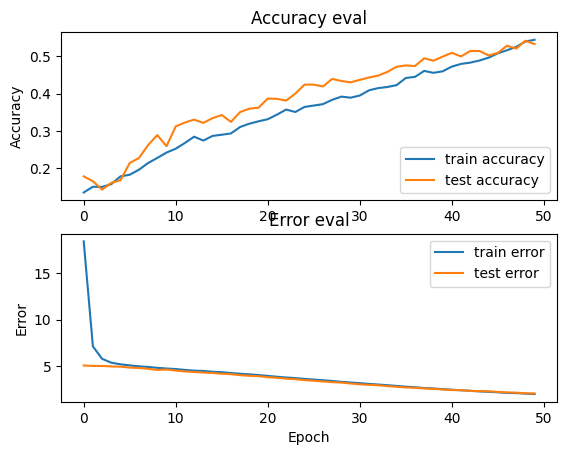

In [26]:
plot_history(hist)

In [27]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5420 - loss: 2.0214
Test accuracy: 0.5330440402030945


We can see that the overfitting is greatly reduced but still we are not able to get a good accuracy. Now we will try doing it with Convolutional Neural Network (CNN)

# CNN
Using keras layers of Conv2D, MaxPool2D, BatchNormalization.

CNN layers takes input primarily in 3D shape, so we again have to prepare the dataset in the form and for that, I have used np.newaxis function which adds a column/layer in the data

In [28]:
def prepare_dataset(test_size, validation_size):
    X,y = load_data(r"./data.json")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = validation_size)
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [29]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(0.25, 0.2)

In [30]:
input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])
print(input_shape)

(130, 13, 1)


In [34]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = "relu", input_shape = input_shape))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (2, 2), activation = "relu"))
model.add(MaxPool2D((2, 2), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(16, (1, 1), activation = "relu"))
model.add(MaxPool2D((1, 1), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 128, 11, 64)         │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 6, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 6, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 62, 4, 32)           │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 31, 2, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 31, 2, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 30, 1, 32)           │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 15, 1, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 15, 1, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 15, 1, 16)           │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 1, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 8, 1, 16)            │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,242 (129.85 KB)

 Trainable params: 32,954 (128.73 KB)

 Non-trainable params: 288 (1.12 KB)

In [38]:
# Recreate the optimizer instance with the correct argument name
adam = optimizers.Adam(learning_rate=1e-4)

# Compile the model with the new optimizer instance
model.compile(optimizer=adam, loss="sparse_categorical_crossentropy", metrics=["accuracy"])


hist = model.fit(X_train, y_train,
                 validation_data = (X_val, y_val),
                 epochs = 40,
                 batch_size = 32)

Epoch 1/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.1570 - loss: 2.6404 - val_accuracy: 0.2877 - val_loss: 1.9871
Epoch 2/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.2807 - loss: 2.0832 - val_accuracy: 0.3705 - val_loss: 1.7536
Epoch 3/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.3496 - loss: 1.8513 - val_accuracy: 0.4166 - val_loss: 1.6122
Epoch 4/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.3952 - loss: 1.7278 - val_accuracy: 0.4493 - val_loss: 1.5085
Epoch 5/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.4171 - loss: 1.6308 - val_accuracy: 0.4940 - val_loss: 1.4239
Epoch 6/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.4425 - loss: 1.5607 - val_accuracy: 0.4907 - val_loss: 1.3780
Epoch 7/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.4597 - loss: 1.4798 - val_accuracy: 0.5254 - val_loss: 1.2980
Epoch 8/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.4774 - loss: 1.4185 - val_acc

In [39]:
model.save('model.h5')

<Figure size 2000x1500 with 0 Axes>

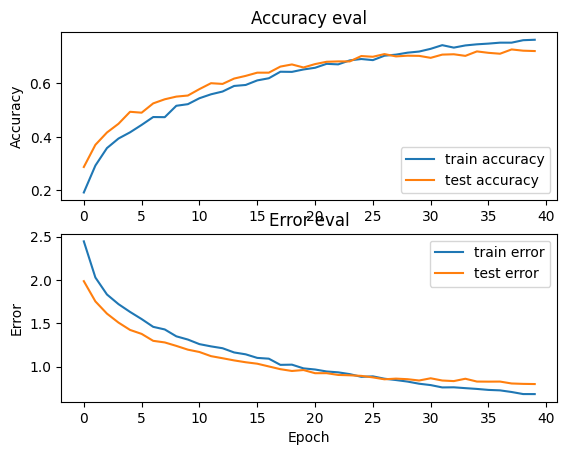

In [40]:
plot_history(hist)

In [41]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7468 - loss: 0.7647
Test accuracy: 0.7344813942909241


In [42]:
def predict(model, X, y):
    X = X[np.newaxis,...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    print(f"Expected index: {y}, Predicted index: {predicted_index}")

In [43]:
predict(model, X_test[10], y_test[10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
Expected index: 7, Predicted index: [7]


As we can see the accuracy has improved by Significant amount but still the accuracy is not enough, in the future of this notebook I am planning to implement RNN model in this and finally use the ensembling to get a push in accuracy. However any other suggestions are always invited!